!pip install ../input/kerasapplications/keras-team-keras-applications-3b180cb -f ./ --no-index
!pip install ../input/efficientnet/efficientnet-1.1.0/ -f ./ --no-index

In [1]:
import os
import cv2
import pydicom
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from tensorflow.keras.layers import (Dense, Dropout, Activation, Flatten, Input, Add,
                                    BatchNormalization, LeakyReLU, Concatenate, GlobalAveragePooling2D,Conv2D, AveragePooling2D)
from tensorflow.keras import Model
from tensorflow.keras.utils import Sequence
import tensorflow.keras.backend as K
import tensorflow.keras.applications as tfa
#import efficientnet.tfkeras as efn
from sklearn.model_selection import train_test_split, KFold
import seaborn as sns


In [2]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

In [3]:
train = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/train.csv')
train.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


In [4]:
def get_tab(df):
    ''' 
    This function gives an array wrt each patient containing
    feature like age, gender and smoking status
    '''
    vector = [(df.Age.values[0]-30)/30]
    
    if df.Sex.values[0].lower() == 'male':
        vector.append(0)
    else:
        vector.append(1)
        
    if df.SmokingStatus.values[0] == 'Never smoked':
        vector.extend([0,0])
    elif df.SmokingStatus.values[0] == 'Ex-smoker':
        vector.extend([1,1])
    elif df.SmokingStatus.values[0] == 'Currently smokes':
        vector.extend([0,1])
    else:
        vector.extend([1,0])
        
    return np.array(vector)

In [5]:
A = {} #Stores slope value for each of the patient
TAB = {} #Stores training data wrt each patient
P = [] #Stores all unique patient id's

for i,p in enumerate(train.Patient.unique()):
    sub = train.loc[train.Patient == p, :]
    fvc = sub.FVC.values
    week = sub.Weeks.values
    c = np.vstack([week, np.ones(len(week))]).T
    a, b = np.linalg.lstsq(c,fvc)[0]
    
    A[p] = a # Contains slope
    TAB[p] = get_tab(sub) #Contains gender and smoking feature
    P.append(p) #contains unique id

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  # Remove the CWD from sys.path while we load stuff.


## Creating CNN architecture for coeficient prediction:

In [6]:
def get_img(path):
    d = pydicom.dcmread(path)
    return cv2.resize(d.pixel_array/2**11 ,(512,512))

In [7]:
# x, y = [], []
# for p in tqdm(train.Patient.unique()):
#     try:
#         ldir = os.listdir(f'osic-pulmonary-fibrosis-progression-lungs-mask/mask_noise/mask_noise/{p}/')

In [8]:
class IGenerator(Sequence):
    
    ''' 
    This is the generator class, which generates an input of batch size 32
    i.e 32 patient's 2 dicom image, and features from tabular data is generated. As output 
    from his generator x and y contains pixel_data of a dicom image, tab conatins patient's meta
    information, and 'a' is the coeffiecient wrt each patient. 
    '''
    BAD_ID = ['ID00011637202177653955184', 'ID00052637202186188008618']
    def __init__(self, keys, a, tab, batch_size=16):
        self.keys = [k for k in keys if k not in self.BAD_ID]
        self.a = a
        self.tab = tab
        self.batch_size = batch_size
        
        self.train_data = {}
        for p in train.Patient.values:
            self.train_data[p] = os.listdir(f'../input/osic-pulmonary-fibrosis-progression/train/{p}/')
    
    def __len__(self):
        return 1000
    
    def __getitem__(self, idx):
        x, y = [], []
        a, tab = [], [] 
        keys = np.random.choice(self.keys, size = self.batch_size)
        
        for k in keys:
            try:
                i = np.random.choice(self.train_data[k], size=1)[0]
                j = np.random.choice(self.train_data[k], size=1)[0]
                img1 = get_img(f'../input/osic-pulmonary-fibrosis-progression/train/{k}/{i}')
                img2 = get_img(f'../input/osic-pulmonary-fibrosis-progression/train/{k}/{j}')
                
                x.append(img1)
                y.append(img2)
                
                a.append(self.a[k])
                tab.append(self.tab[k])
            except:
                print(k, i)
        
        
        x,y,a,tab = np.array(x),np.array(y), np.array(a), np.array(tab)
        x = np.expand_dims(x, axis=-1)
        y = np.expand_dims(y, axis=-1)
        return [x,y, tab] , a

In [9]:
def model_architechture(shape=(512,512,1)):
    '''Architecture used here is inspired by this kaggle notebook 
    https://www.kaggle.com/miklgr500/linear-decay-based-on-resnet-cnn/notebook'''
    
    def res_block(x, filter_number):
        _x = x
        x = Conv2D(filter_number, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.05)(x)
        x = Conv2D(filter_number, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
        x = LeakyReLU(0.05)(x)
        
        x = Add()([_x, x])
        return x
    
    #two input branch for images
    input1 = Input(shape=shape, name= 'dicom_image_1')
    input2 = Input(shape=shape, name= 'dicom_image_2')
    
    #image input branch 1 begins
    x = Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same')(input1)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.05)(x)
    
    x = Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.05)(x)
    
    x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    
    #image input branch 2 begins
    y = Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same')(input2)
    y = BatchNormalization()(y)
    y = LeakyReLU(0.05)(y)
    
    y = Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same')(y)
    y = BatchNormalization()(y)
    y = LeakyReLU(0.05)(y)
    
    y = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(y)
    
    #Concatinating image inputs
    x_and_y = Concatenate()([x, y])
    
    x_and_y = Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same')(x_and_y)
    x_and_y = BatchNormalization()(x_and_y)
    x_and_y = LeakyReLU(0.05)(x_and_y)
    
    x_and_y = Conv2D(16, kernel_size=(3, 3), strides=(1, 1), padding='same')(x_and_y)
    for _ in range(2):
        x_and_y = res_block(x_and_y, 16)
    x_and_y = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x_and_y)
    
    x_and_y = Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same')(x_and_y)
    for _ in range(3):
        x_and_y = res_block(x_and_y, 64)
    x_and_y = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x_and_y)    
    
    x_and_y = Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same')(x_and_y)
    for _ in range(1):
        x_and_y = res_block(x_and_y, 128)
        
   
    x_and_y = GlobalAveragePooling2D()(x_and_y)
    
    #Patient tabular data input
    input3 = Input(shape=(4,))
    z = tf.keras.layers.GaussianNoise(0.2)(input3)
    xyz = Concatenate()([x_and_y, z])
    xyz = Dropout(0.6)(xyz) 
    xyz = Dense(1)(xyz)
    return Model([input1, input2, input3] , xyz)

In [10]:
model = model_architechture()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mae') 

tr_p, vl_p = train_test_split(P, shuffle=True, train_size= 0.8)

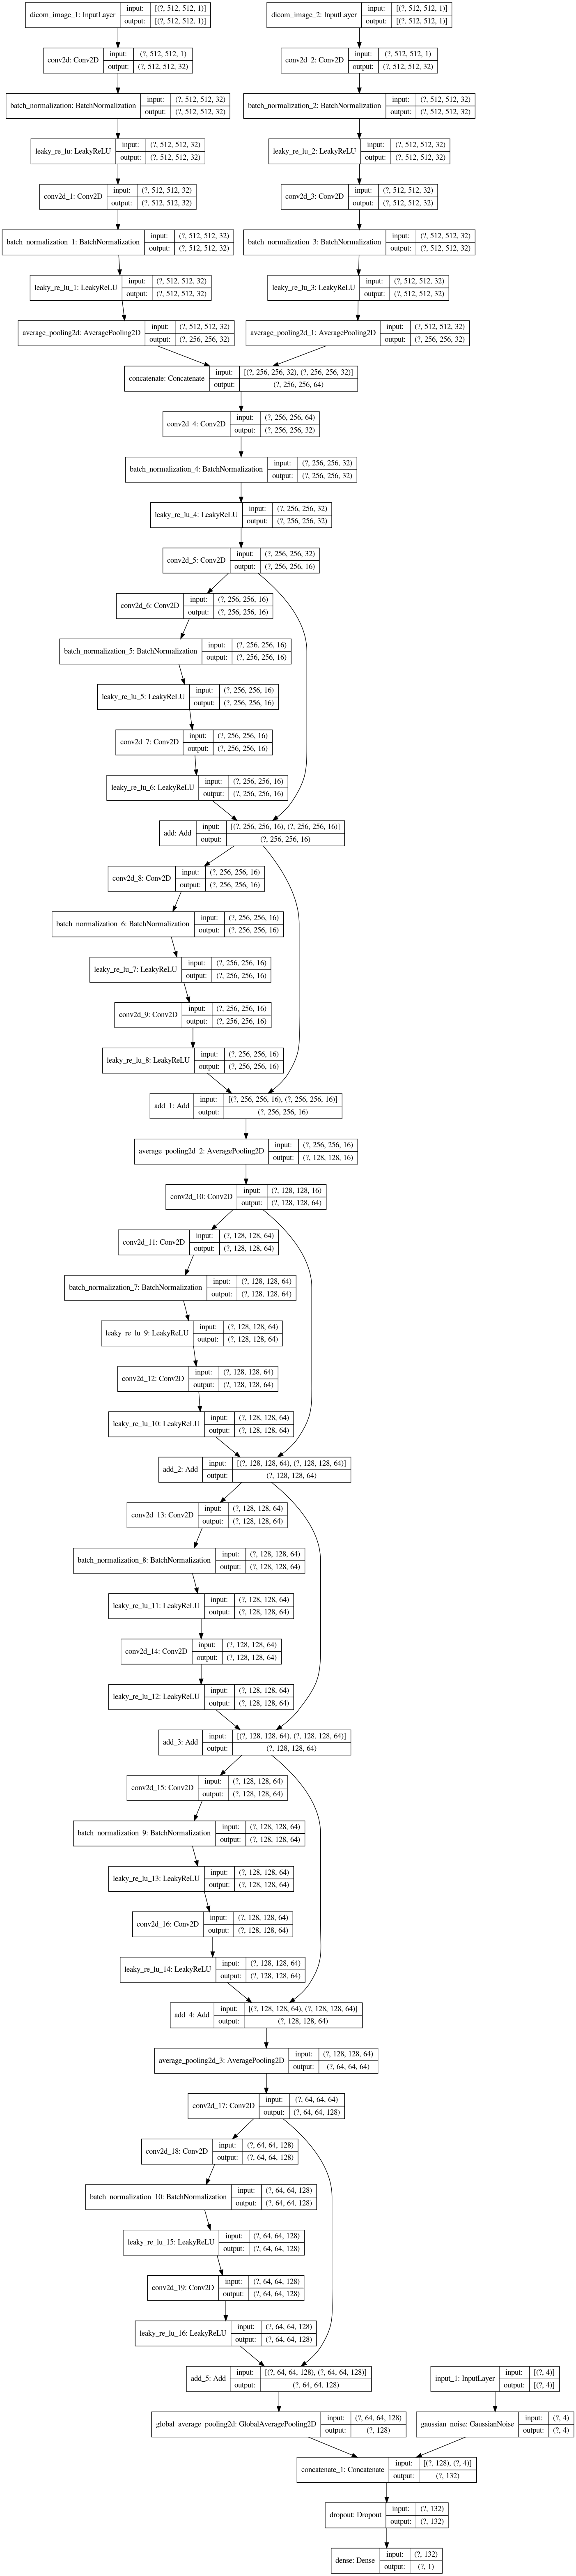

In [11]:
from tensorflow import keras
keras.utils.plot_model(model,'img.png', show_shapes=True)

In [12]:
er = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=1e-3,
    patience=5,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

model.fit_generator(IGenerator(keys=tr_p, 
                               a = A, 
                               tab = TAB), 
                    steps_per_epoch = 200,
                    validation_data=IGenerator(keys=vl_p, 
                               a = A, 
                               tab = TAB),
                    validation_steps = 20, 
                    callbacks = [er], 
                    epochs=30)

Epoch 1/30
200/200 [==============================] - 115s 577ms/step - loss: 4.8684 - val_loss: 4.0944
Epoch 2/30
200/200 [==============================] - 95s 475ms/step - loss: 4.5993 - val_loss: 4.3466
Epoch 3/30
200/200 [==============================] - 90s 449ms/step - loss: 4.4819 - val_loss: 3.7372
Epoch 4/30
200/200 [==============================] - 87s 435ms/step - loss: 4.4240 - val_loss: 4.0386
Epoch 5/30
200/200 [==============================] - 87s 437ms/step - loss: 4.4599 - val_loss: 4.2364
Epoch 6/30
200/200 [==============================] - 87s 434ms/step - loss: 4.4671 - val_loss: 4.0906
Epoch 7/30
200/200 [==============================] - 85s 427ms/step - loss: 4.4745 - val_loss: 3.9720
Epoch 8/30
200/200 [==============================] - 85s 426ms/step - loss: 4.3685 - val_loss: 3.9160


In [13]:
model.save('best_model.h5')

In [14]:
#model = tf.keras.models.load_model('./best_model.h5')

In [15]:
def score(fvc_true, fvc_pred, sigma):
    sigma_clip = np.maximum(sigma,70)
    delta = np.abs(fvc_true - fvc_pred)
    delta = np.minimum(delta,1000)
    sqrt = np.sqrt(2)
    metric = (delta/sigma_clip)*sqrt + np.log(sigma_clip*sqrt)
    return np.mean(metric)

In [16]:
from tqdm.notebook import tqdm

metric = []
for q in tqdm(range(1, 10)):
    m = []
    for p in vl_p:
        x, y = [], []
        tab = [] 
        
        if p in ['ID00011637202177653955184', 'ID00052637202186188008618']:
            continue
            
        img_set = os.listdir(f'../input/osic-pulmonary-fibrosis-progression/train/{p}/')
        img_set = np.random.choice(img_set, size=20)
        for i in img_set:
            x.append(get_img(f'../input/osic-pulmonary-fibrosis-progression/train/{p}/{i}')) 
            y.append(get_img(f'../input/osic-pulmonary-fibrosis-progression/train/{p}/{i}'))
            tab.append(get_tab(train.loc[train.Patient == p, :])) 
        tab = np.array(tab) 
    
        x = np.expand_dims(x, axis=-1)
        y = np.expand_dims(y, axis=-1)
        _a = model.predict([x,y, tab]) 
        a = np.quantile(_a, q / 10)
        
        percent_true = train.Percent.values[train.Patient == p]
        fvc_true = train.FVC.values[train.Patient == p]
        weeks_true = train.Weeks.values[train.Patient == p]
        
        fvc = a * (weeks_true - weeks_true[0]) + fvc_true[0]
        percent = percent_true[0] - a * abs(weeks_true - weeks_true[0])
        m.append(score(fvc_true, fvc, percent))
    print(np.mean(m))
    metric.append(np.mean(m))

6.626517996760767
6.624999733225759
6.625550094580061
6.624932882888647
6.623206434406823
6.62146245869845
6.624465092245878
6.6217406479535805
6.621470405665796



In [17]:
q = (np.argmin(metric) + 1)/ 10
q

0.6

In [18]:
sub = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/sample_submission.csv') 
sub.head() 

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,2000,100
1,ID00421637202311550012437_-12,2000,100
2,ID00422637202311677017371_-12,2000,100
3,ID00423637202312137826377_-12,2000,100
4,ID00426637202313170790466_-12,2000,100


In [19]:
test = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv') 
test.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00419637202311204720264,6,3020,70.186855,73,Male,Ex-smoker
1,ID00421637202311550012437,15,2739,82.045291,68,Male,Ex-smoker
2,ID00422637202311677017371,6,1930,76.672493,73,Male,Ex-smoker
3,ID00423637202312137826377,17,3294,79.258903,72,Male,Ex-smoker
4,ID00426637202313170790466,0,2925,71.824968,73,Male,Never smoked


In [20]:
A_test, B_test, P_test,W, FVC= {}, {}, {},{},{} 
STD, WEEK = {}, {} 
for p in test.Patient.unique():
    x,y = [],[]
    tab = [] 
    img_set = os.listdir(f'../input/osic-pulmonary-fibrosis-progression/test/{p}/')
    img_set = np.random.choice(img_set, size=20)
    for i in img_set:
        x.append(get_img(f'../input/osic-pulmonary-fibrosis-progression/test/{p}/{i}')) 
        y.append(get_img(f'../input/osic-pulmonary-fibrosis-progression/test/{p}/{i}'))
        tab.append(get_tab(test.loc[test.Patient == p, :])) 
    tab = np.array(tab) 
            
    x = np.expand_dims(x, axis=-1) 
    y = np.expand_dims(y, axis=-1) 
    _a = model.predict([x,y, tab]) 
    a = np.quantile(_a, q)
    A_test[p] = a
    B_test[p] = test.FVC.values[test.Patient == p] - a*test.Weeks.values[test.Patient == p]
    P_test[p] = test.Percent.values[test.Patient == p] 
    WEEK[p] = test.Weeks.values[test.Patient == p]

In [21]:
for k in sub.Patient_Week.values:
    p, w = k.split('_')
    w = int(w) 
    
    fvc = A_test[p] * w + B_test[p]
    sub.loc[sub.Patient_Week == k, 'FVC'] = fvc
    sub.loc[sub.Patient_Week == k, 'Confidence'] = (
        P_test[p] - A_test[p] * abs(WEEK[p] - w) 
) 
sub.head()

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,3081.527211,131.714067
1,ID00421637202311550012437_-12,2866.865711,209.911002
2,ID00422637202311677017371_-12,2008.392895,155.065388
3,ID00423637202312137826377_-12,3440.202631,225.461534
4,ID00426637202313170790466_-12,2984.511673,131.336641


In [22]:
sub[["Patient_Week","FVC","Confidence"]].to_csv("submission.csv", index=False)

def get_model(shape=(512, 512, 1)):
    def res_block(x, n_features):
        _x = x
        x = BatchNormalization()(x)
        x = LeakyReLU(0.05)(x)
    
        x = Conv2D(n_features, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
        x = Add()([_x, x])
        return x
    
    input1 = Input(shape=shape, name= 'dicom_image_1')
    #input2 = Input(shape=shape, name= 'dicom_image_2')
    
    # 512
    x = Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same')(input1)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.05)(x)
    
    x = Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.05)(x)
    
    x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    
    # 256
    x = Conv2D(8, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    for _ in range(2):
        x = res_block(x, 8)
    x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    
    # 128
    x = Conv2D(16, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    for _ in range(2):
        x = res_block(x, 16)
    x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    
    # 64
    x = Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    for _ in range(3):
        x = res_block(x, 32)
    x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    
    # 32
    x = Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    for _ in range(3):
        x = res_block(x, 64)
    x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)    
    
    # 16
    x = Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    for _ in range(3):
        x = res_block(x, 128)
        
    # 16
    x = GlobalAveragePooling2D()(x)
    
    inp2 = Input(shape=(4,))
    x2 = tf.keras.layers.GaussianNoise(0.2)(inp2)
    x = Concatenate()([x, x2]) 
    x = Dropout(0.6)(x) 
    x = Dense(1)(x)
    #x2 = Dense(1)(x)
    return Model([input1, inp2] , x)


# Defining model

def get_efficientnet(model, shape):
    models_dict = {
        'b0': efn.EfficientNetB0(input_shape=shape, weights=None,include_top=False),
        'b1': efn.EfficientNetB1(input_shape=shape,weights=None,include_top=False),
        'b2': efn.EfficientNetB2(input_shape=shape,weights=None,include_top=False),
        'b3': efn.EfficientNetB3(input_shape=shape,weights=None,include_top=False),
        'b4': efn.EfficientNetB4(input_shape=shape,weights=None,include_top=False),
        'b5': efn.EfficientNetB5(input_shape=shape,weights=None,include_top=False),
        'b6': efn.EfficientNetB6(input_shape=shape,weights=None,include_top=False),
        'b7': efn.EfficientNetB7(input_shape=shape,weights=None,include_top=False)
        }
    return models_dict[model]

def build_model(shape=(512,512,1), model_class=None):
    inp = Input(shape=shape)
    base = get_efficientnet(model_class, shape)
    x = base(inp)
    x = GlobalAveragePooling2D()(x)
    inp2 = Input(shape=(4,))
    x2 = tf.keras.layers.GaussianNoise(0.2)(inp2)
    x = Concatenate()([x,x2])
    x = Dropout(0.5)(x)
    x = Dense(1)(x)
    model = Model([inp,inp2],x)
    return model

# Training

P = np.array(P)
subs = []
folds_history = []

er = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=1e-3,
    patience=10,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

cpt = tf.keras.callbacks.ModelCheckpoint(
    filepath=f'effnet_{EPOCHS}.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only = SAVE_BEST,
    mode = 'auto'
)

rlp = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=1e-8
)
model = build_model(model_class = MODEL_CLASS)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss='mae')
history = model.fit_generator(IGenerator(keys=P,
                                        a= A,
                                        tab= TAB),
                             steps_per_epoch = 32,
                             validation_data = IGenerator(keys=P,
                                                         a = A,
                                                         tab = TAB),
                             validation_steps = 16,
                             callbacks = [cpt,rlp],
                             epochs = EPOCHS)
folds_history.append(history.history)
print('Trainig Done!')


<a href='./training_1'> Download File</a>